### Importing Libraries.

In [190]:
# Pandas: This librarie will used to create and work with dataframes.
import pandas as pd 
# Matplotlib: Used to plot graphics. 
import matplotlib.pyplot as plt
# Seaborn: Used to better style and iprove graphics. 
import seaborn as sns
#Tweepy: Used to work with the Twitter API.
import tweepy as tw
#ConfigParser: Used to get credentials for the twitter API.
import configparser as cp
#NLTK its used to pre-proccess text and regex its used to filter that text.
import nltk, re
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = stopwords.words('english')
normalizer = WordNetLemmatizer()
#Library to count words
from collections import Counter
# library to bluid wordclouds
from wordcloud import WordCloud
# NLTK to analice sentiment. 
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Importing and authenticating API credentials from the config file. 

In [191]:
config =  cp.ConfigParser()
config.read("config.ini")

api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_key_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

# Authentication

auth = tw.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth)

### Funtions to work with in this project.

In [192]:

# Function to perform data extraction from twitter.
def scrape(words, date_since, numtweet):
# We are using .Cursor() to search
# through twitter for the required tweets.
# The number of tweets can be
# restricted using .items(number of tweets)
    tweets = tw.Cursor(api.search_tweets,
                               words, lang="en",
                               since_id=date_since,
                               tweet_mode='extended').items(numtweet)
# .Cursor() returns an iterable object. Each item in
# the iterator has various attributes
# that you can access to
# get information about each tweet
    list_tweets = [tweet for tweet in tweets]
 
# we will iterate over each tweet in the
# list for extracting information about each tweet
    columns=['tweet_date','tweets']
    data = []
    for tweet in list_tweets:
        tweet_date = tweet.created_at
# Retweets can be distinguished by
# a retweeted_status attribute,
# in case it is an invalid reference,
# except block will be executed
        try:
            tweets = tweet.retweeted_status.full_text
        except AttributeError:
            tweets = tweet.full_text
            data.append([tweet_date, tweets])
# Creating DataFrame using pandas
    df = pd.DataFrame(data, columns=columns)
    return df 

#Functions to preproccess text.
def get_part_of_speech(word):
  probable_part_of_speech = wordnet.synsets(word)
  pos_counts = Counter()
  pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
  most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
  return most_likely_part_of_speech

def preprocess_text(text):
  cleaned = re.sub(r'(\W+)|(http\S+)', ' ', text).lower()
  tokenized = word_tokenize(cleaned)
  normalized = [normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized if token not in stop_words]
  return normalized

# Cleaning text. 
def clean_text(text):
  cleaned = re.sub(r'(\W+)|(http\S+)', ' ', text).lower()
  return cleaned

# Funtion to bluid and plot a WordCloud.
def wordcloud(str):
    wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(str))
#plot the wordcloud object
    plt.figure(figsize = (8,8))
    plt.imshow(wordcloud, interpolation='bilInear')
    plt.axis('off')
    plt.show()

#Sentiment finder
def sentiment(text):
    score = sia.polarity_scores(text)
    pos = score["pos"]
    neg = score["neg"]
    if pos > neg:
        sentiment = "positive"
    elif neg > pos:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    return sentiment


### Getting the data from twitter.

In [223]:
tesla = scrape("Tesla", 2022-0o1-0o1, 1000)
ford = scrape("Ford", 2022-0o1-0o1, 1000)

### Preproccessing the data for further analisys.

In [224]:
tesla_preprocess = preprocess_text("".join(tesla.tweets))
ford_preprocess = preprocess_text("".join(ford.tweets))

### Counting words with bag of words

In [225]:
tesla_bow = Counter(tesla_preprocess)
ford_bow = Counter(ford_preprocess)

print("\nThen most frequent words and number of occurrences for Tesla according to Bag-of-Words:")
most_common_tesla = tesla_bow.most_common(10)
print(most_common_tesla)
print("\nTen most frequent words and number of occurrences for Ford according to Bag-of-Words:")
most_common_ford = ford_bow.most_common(10)
print(most_common_ford)


Then most frequent words and number of occurrences for Tesla according to Bag-of-Words:
[('tesla', 479), ('elonmusk', 284), ('make', 73), ('2', 66), ('elon', 65), ('musk', 62), ('car', 58), ('000', 57), ('last', 56), ('month', 50)]

Ten most frequent words and number of occurrences for Ford according to Bag-of-Words:
[('ford', 358), ('amp', 33), ('car', 31), ('ebay', 27), ('one', 27), ('1', 26), ('henry', 26), ('get', 24), ('like', 22), ('make', 20)]


### Building a WordCloud

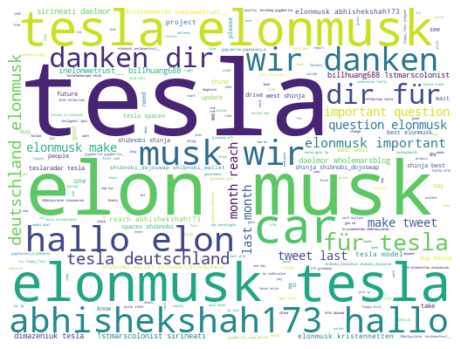

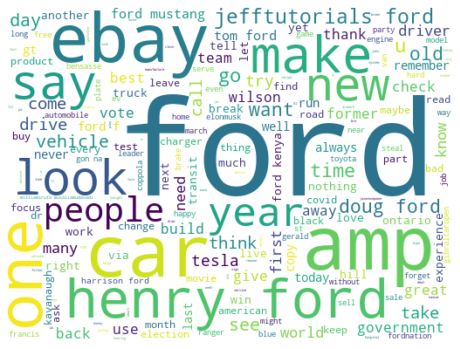

In [226]:
tesla_wordcloud = wordcloud(tesla_preprocess)
ford_wordcloud = wordcloud(ford_preprocess)

### Finding the sentiment of each tweet using nltk SentimentIntensityAnalyzer

In [227]:
# In this case we just need to clean the data and create a new column with it.
tesla["clean_tweet"] = tesla["tweets"].apply(clean_text)
ford["clean_tweet"] = ford["tweets"].apply(clean_text)
# Now we can apply the sentiment function and create a new column with it.
tesla["sentiment"] = tesla["clean_tweet"].apply(sentiment)
ford["sentiment"] = ford["clean_tweet"].apply(sentiment)
print(ford.tail())
print(tesla.tail())

                   tweet_date  \
379 2022-03-26 09:13:07+00:00   
380 2022-03-26 09:11:23+00:00   
381 2022-03-26 09:11:16+00:00   
382 2022-03-26 09:10:08+00:00   
383 2022-03-26 09:09:50+00:00   

                                                tweets  \
379  Me getting Courtney Ford to sign something wit...   
380  @harleydavidson Difficult choice... Henry Ford...   
381  @JeffTutorials @Ford yes bro this is not good ...   
382  Henry Ford didn't revolutionize the automobile...   
383  @NinaByzantina We also can't forget Henry Ford...   

                                           clean_tweet sentiment  
379  me getting courtney ford to sign something wit...  positive  
380   harleydavidson difficult choice henry ford ke...  positive  
381   jefftutorials ford yes bro this is not good w...  positive  
382  henry ford didn t revolutionize the automobile...   neutral  
383   ninabyzantina we also can t forget henry ford...  negative  
                   tweet_date  \
446 2022-03-26 10

### Sentiment count per company.

In [247]:
# Total sentiment count
total_tesla_sentiment_count =  tesla.groupby('sentiment')['sentiment'].count()
df = total_tesla_sentiment_count.to_frame()
print(df.columns)
#df = pd.DataFrame(total_tesla_sentiment_count, columns=("tweet_date", "sentiment", "count"))
print(df)
#total_ford_sentiment_count =  ford.groupby('sentiment')['sentiment'].count()
print("Total sentiment count of Ford:")
print(total_ford_sentiment_count)
print("\nTotal sentiment count of Tesla: ")
#total_tesla_sentiment_count
# Sentiment count by day
day_tesla_sentiment_count = tesla.groupby([pd.Grouper(key='tweet_date', axis=0, 
                      freq='D', sort=True), "sentiment"])['sentiment'].count()
day_ford_sentiment_count = ford.groupby([pd.Grouper(key='tweet_date', axis=0, 
                      freq='D', sort=True), "sentiment"])['sentiment'].count()
day_tesla_sentiment_count

Index(['sentiment'], dtype='object')
           sentiment
sentiment           
negative          82
neutral          116
positive         253
Total sentiment count of Ford:
sentiment
negative     85
neutral     130
positive    169
Name: sentiment, dtype: int64

Total sentiment count of Tesla: 


tweet_date                 sentiment
2022-03-26 00:00:00+00:00  negative      82
                           neutral      116
                           positive     253
Name: sentiment, dtype: int64

### Sentiments BarCharts

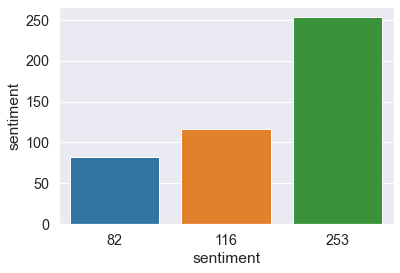

In [245]:
sns.barplot(x="sentiment", y="sentiment", data=df)
plt.show()

### Change in sentiment Over time 

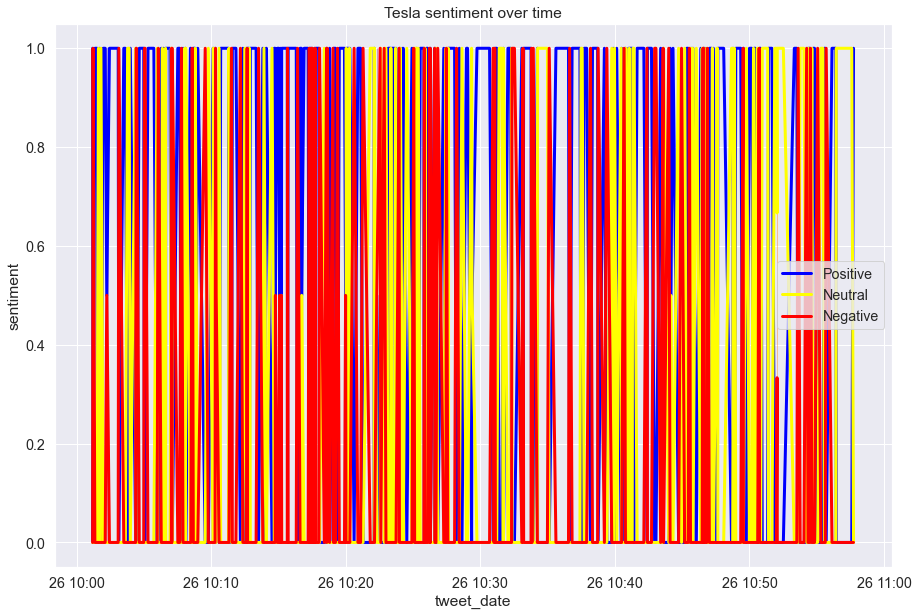

In [229]:
plt.figure(figsize=(15,10))
plt.title("Tesla sentiment over time")
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 3}, font_scale=1.3)
sns.lineplot(x=tesla.tweet_date, y=tesla.sentiment == "positive", data=tesla, color="blue", label="Positive")
sns.lineplot(x=tesla.tweet_date, y=tesla.sentiment == "neutral", data=tesla, color="yellow", label="Neutral")
sns.lineplot(x=tesla.tweet_date, y=tesla.sentiment == "negative", data=tesla, color="red", label="Negative")
plt.legend()
plt.show()

### Lista de palabras por sentimiento y comparar si se mezclan

### 2-Grams y 3-Grams y graficar como se conectan.